In [19]:
import numpy as np 
import pickle,os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append("..")
from nets import Nets
from utils import *




from postprocessing import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import re

In [2]:
experiment_folder = "/Users/daniellengyel/flat_sharp/flat_sharp/experiments/gaussian/{}".format("Apr03_17-38-00_Daniels-MacBook-Pro-4.local")#"/Users/daniellengyel/flat_sharp/gaussian/gaussian_experiments/Apr03_17-38-00_Daniels-MacBook-Pro-4.local"
# configs = get_configs(experiment_folder)

In [13]:
# get runs 
runs = get_runs(experiment_folder, ["Loss"])

/Users/daniellengyel/flat_sharp/flat_sharp/experiments/gaussian/Apr03_17-38-00_Daniels-MacBook-Pro-4.local/runs/1585931450.079084
/Users/daniellengyel/flat_sharp/flat_sharp/experiments/gaussian/Apr03_17-38-00_Daniels-MacBook-Pro-4.local/runs/1585938556.9890182
/Users/daniellengyel/flat_sharp/flat_sharp/experiments/gaussian/Apr03_17-38-00_Daniels-MacBook-Pro-4.local/runs/1585929058.874381
/Users/daniellengyel/flat_sharp/flat_sharp/experiments/gaussian/Apr03_17-38-00_Daniels-MacBook-Pro-4.local/runs/1585930974.450449
/Users/daniellengyel/flat_sharp/flat_sharp/experiments/gaussian/Apr03_17-38-00_Daniels-MacBook-Pro-4.local/runs/1585934302.062954
/Users/daniellengyel/flat_sharp/flat_sharp/experiments/gaussian/Apr03_17-38-00_Daniels-MacBook-Pro-4.local/runs/1585928292.1530418
/Users/daniellengyel/flat_sharp/flat_sharp/experiments/gaussian/Apr03_17-38-00_Daniels-MacBook-Pro-4.local/runs/1585928292.2605288
/Users/daniellengyel/flat_sharp/flat_sharp/experiments/gaussian/Apr03_17-38-00_Daniels-

In [47]:
with open(os.path.join(experiment_folder, "eig_tmp.pkl"), "rb") as f:
    eigs = pickle.load(f)
    
with open(os.path.join(experiment_folder, "acc_tmp.pkl"), "rb") as f:
    accs = pickle.load(f)

In [ ]:
# next step, get accuracy here... sucks we can't get it otherwise

In [23]:
configs = get_configs(experiment_folder)
config_to_id_map = get_config_to_id_map(configs)

In [17]:
config = {'batch_test_size': 100,
 'batch_train_size': 16,
 'ess_threshold': 0.95,
 'learning_rate': 0.001,
 'momentum': 0,
 'net_name': 'SimpleNet',
 'net_params': None, #[2, 2, 256, 1],
 'num_steps': 1600,
 'num_nets': 100,
 'softmax_beta': None, #0,
 'torch_random_seed': 1,
 'weight_type': 'loss_gradient_weights'}

In [25]:
ids = get_ids(config_to_id_map, config)

In [26]:
for i in ids:
    print(i)
    print(configs[i])

1585929058.874381
{'batch_test_size': 100, 'batch_train_size': 16, 'ess_threshold': 0.95, 'learning_rate': 0.001, 'momentum': 0, 'net_name': 'SimpleNet', 'net_params': [2, 2, 4, 1], 'num_nets': 100, 'num_steps': 1600, 'softmax_beta': -10, 'torch_random_seed': 1, 'weight_type': 'loss_gradient_weights'}
1585928292.0770292
{'batch_test_size': 100, 'batch_train_size': 16, 'ess_threshold': 0.95, 'learning_rate': 0.001, 'momentum': 0, 'net_name': 'SimpleNet', 'net_params': [2, 2, 4, 1], 'num_nets': 100, 'num_steps': 1600, 'softmax_beta': -75, 'torch_random_seed': 1, 'weight_type': 'loss_gradient_weights'}
1585934392.164982
{'batch_test_size': 100, 'batch_train_size': 16, 'ess_threshold': 0.95, 'learning_rate': 0.001, 'momentum': 0, 'net_name': 'SimpleNet', 'net_params': [2, 2, 4, 1], 'num_nets': 100, 'num_steps': 1600, 'softmax_beta': 10, 'torch_random_seed': 1, 'weight_type': 'loss_gradient_weights'}
1585937262.7277231
{'batch_test_size': 100, 'batch_train_size': 16, 'ess_threshold': 0.95, 

1585929058.874381
1585928292.0770292
1585934392.164982
1585937262.7277231
1585931684.0249321


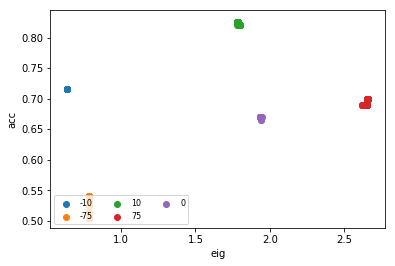

NEXT
err
1585938359.861946
1585933368.4366121
err
1585935434.029075


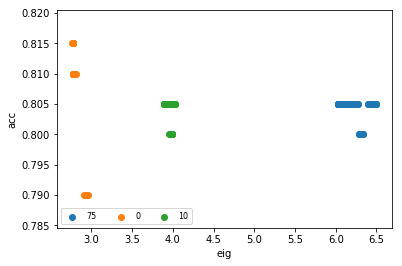

NEXT
1585928292.091854
1585934030.712699
1585936880.102571
1585931172.3658938
1585939630.681816


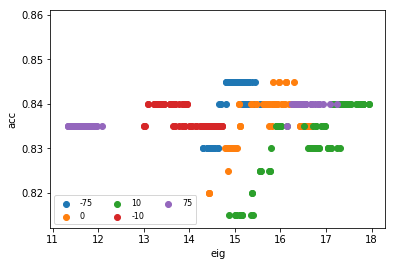

NEXT


In [51]:
for w in [4, 32, 256]:
    config['net_params'] = [2, 2, w, 1]
    ids = get_ids(config_to_id_map, config)
    
    plots = []
    plots_names = []
    for i in ids:
        
        
        try:
            Y = [accs[i][str(nn)] for nn in range(100)]
            X = [eigs[i][str(nn)][0][-1] for nn in range(100)]
            
            plots.append(plt.scatter(np.array(X), np.array(Y), ))
            plots_names.append(configs[i]["softmax_beta"])
            print(i)
        except:
            print("err")
            continue
            
    plt.legend(tuple(plots),
           plots_names,
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)


    plt.xlabel("eig")
    plt.ylabel("acc")

    plt.show()
    
    print("NEXT")


1585929058.874381
1585928292.0770292
1585934392.164982
1585937262.7277231
1585931684.0249321


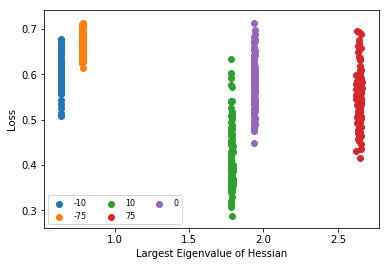

NEXT
err
1585938359.861946
1585933368.4366121
err
1585935434.029075


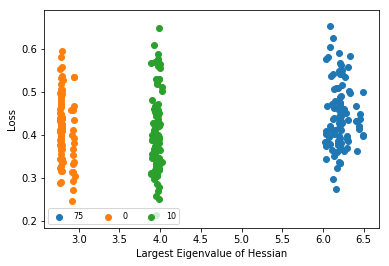

NEXT
1585928292.091854
1585934030.712699
1585936880.102571
1585931172.3658938
1585939630.681816


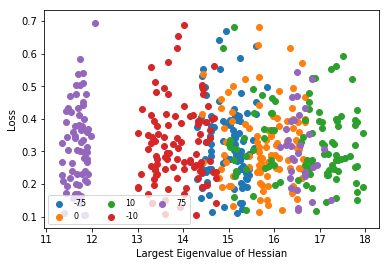

NEXT


In [50]:
for w in [4, 32, 256]:
    config['net_params'] = [2, 2, w, 1]
    ids = get_ids(config_to_id_map, config)
    
    plots = []
    plots_names = []
    for i in ids:
        
        
        try:
            X = [eigs[i][str(nn)][0][-1] for nn in range(100)]
            Y = [runs[i][1599]["Loss"]["train"]["net"][str(nn)] for nn in range(100)]
            
            plots.append(plt.scatter(np.array(X), np.array(Y), ))
            plots_names.append(configs[i]["softmax_beta"])
            print(i)
        except:
            print("err")
            continue
            
    plt.legend(tuple(plots),
           plots_names,
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)


    plt.xlabel("Largest Eigenvalue of Hessian")
    plt.ylabel("Loss")

    plt.show()
    
    print("NEXT")


In [ ]:
import time

In [ ]:
# errors
errs = ["1585931450.079084",
"1585938556.9890182",
"1585930974.450449",
"1585928292.0912151",
"1585928292.195146",
"1585939435.9856498",
"1585930892.8467379",
"1585936404.000936",
"1585928292.161804",
"1585930890.959148",
"1585933418.320897",
"1585930956.739653",
"1585928292.110432"]

In [ ]:
def get_all_model_steps(resampling_dir):
    step_dir = {}
    for root, dirs, files in os.walk(resampling_dir):
        for sample_step_dir in dirs:
            name_split_underscore = sample_step_dir.split("_")
            if len(name_split_underscore) == 1:
                continue
            step_dir[int(name_split_underscore[1])] = sample_step_dir
    return step_dir

In [ ]:
from sklearn.manifold import TSNE


# get all tsne embeddings
def get_tsne_dict(experiment_folder, curr_dir):
    tsne_dict = {}
    step_dir = get_all_model_steps(os.path.join(experiment_folder, "resampling", curr_dir))
    for step in sorted(step_dir):
        print(step)
        models, sampled_idx = get_models(os.path.join(experiment_folder, "resampling", curr_dir), step)
        models_vecs = np.array([get_params_vec(m) for m in models.values()])

        X_embedded = TSNE(n_components=2).fit_transform(models_vecs)

        tsne_dict[step] = X_embedded
    return tsne_dict

In [ ]:
for i in sorted(tsne_dict):
    print(i)
    plt.scatter(tsne_dict[i][:, 0], tsne_dict[i][:, 1])
    plt.show()
    

In [ ]:
curr_dir = "1585931172.3658938"


In [ ]:
tsne_dict = get_tsne_dict(experiment_folder, curr_dir)
for i in sorted(tsne_dict):
    print(i)
    plt.scatter(tsne_dict[i][:, 0], tsne_dict[i][:, 1])
    plt.show()

In [ ]:


models, sampled_idx = get_models(os.path.join(experiment_folder, "resampling", curr_dir), 0)
models_vecs = np.array([get_params_vec(m) for m in models.values()])

shortest_distance = float("inf")
shortest_pair = (None, None)

largest_distance = -float("inf")
largest_pair = (None, None)
for i in range(len(models_vecs)):
    for j in range(i + 1, len(models_vecs)):
        if np.linalg.norm(models_vecs[i] - models_vecs[j]) < shortest_distance:
            shortest_distance = np.linalg.norm(models_vecs[i] - models_vecs[j])
            shortest_pair = (i, j)
        if np.linalg.norm(models_vecs[i] - models_vecs[j]) > largest_distance:
            largest_distance = np.linalg.norm(models_vecs[i] - models_vecs[j])
            largest_pair = (i, j)


In [ ]:
shortest_distance

In [ ]:
largest_distance
np.linalg.norm(models_vecs[0])

In [ ]:
with open(os.path.join(experiment_folder, "data.pkl"), "rb") as f:
    data = pickle.load(f)

train_loader = DataLoader(data[0], batch_size=len(data[0]), shuffle=True)  # fix the batch size
test_loader = DataLoader(data[1], batch_size=len(data[1]))

largest_arr = []
largest_acc = []
shortest_arr = []
shortest_acc = []

largest_mags = []
shortest_mags = []

step_dir = get_all_model_steps(os.path.join(experiment_folder, "resampling", curr_dir))
for step in sorted(step_dir):
    print(step)
    models, sampled_idx = get_models(os.path.join(experiment_folder, "resampling", curr_dir), step)
    models_vecs = np.array([get_params_vec(m) for m in models.values()])
    
    largest_arr.append(np.linalg.norm(models_vecs[largest_pair[0]] - models_vecs[largest_pair[1]]))
    shortest_arr.append(np.linalg.norm(models_vecs[shortest_pair[0]] - models_vecs[shortest_pair[1]]))
    
    largest_acc.append([get_net_accuracy(models[str(largest_pair[0])], test_loader), get_net_accuracy(models[str(largest_pair[1])], test_loader)])
    shortest_acc.append([get_net_accuracy(models[str(shortest_pair[0])], test_loader), get_net_accuracy(models[str(shortest_pair[1])], test_loader)])


    largest_mags.append([np.linalg.norm(models_vecs[largest_pair[0]]), np.linalg.norm(models_vecs[largest_pair[1]])])
    shortest_mags.append([np.linalg.norm(models_vecs[shortest_pair[0]]),np.linalg.norm(models_vecs[shortest_pair[1]])])

In [ ]:
plt.plot(list(sorted(step_dir)), largest_arr )
plt.show()
plt.plot(list(sorted(step_dir)), np.array(largest_acc)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(largest_acc)[:, 1])
plt.show()

plt.plot(list(sorted(step_dir)), np.array(shortest_acc)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(shortest_acc)[:, 1])
plt.show()


plt.plot(list(sorted(step_dir)), np.array(largest_mags)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(largest_mags)[:, 1])
plt.show()

plt.plot(list(sorted(step_dir)), np.array(shortest_mags)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(shortest_mags)[:, 1])
plt.show()

In [ ]:
largest_acc